### Imports

In [111]:
from sklearn.datasets import fetch_lfw_people
from matplotlib import pyplot as plt
from matplotlib.pyplot import imread
import numpy as np
import seaborn as sns
import scipy

import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout
from keras.models import Model
from sklearn.model_selection import train_test_split
from keras import metrics # https://keras.io/metrics/ - ver a parte de custom metrics
from keras.callbacks import History 
from keras.utils.vis_utils import plot_model

import tensorflow as tf


### Funções minhas

In [79]:
# Adicionando ruído às imagens
def add_noise_multiplicative(sigma, bw_img):
    """Adiciona ruído multiplicativo a uma imagem em escala de cinza com valores entre 0 e 1"""
    sh = bw_img.shape
    noise = np.random.normal(1, sigma, sh)
    newgray = bw_img * noise
    return newgray

def add_noise(sigma, bw_img):
    """Adiciona ruído multiplicativo a uma imagem em escala de cinza com valores entre 0 e 1"""
    sh = bw_img.shape
    noise = np.random.normal(0, sigma, sh)
    newgray = bw_img + noise
    return newgray

def plot_original_reconstructed(pred, conj, numero):
    figures, axes = plt.subplots(1, 3)
    axes[0].imshow(faces[numero].reshape(60, 44), cmap = 'gray')
    axes[0].set_title('Original image')
    axes[1].imshow(conj[numero].reshape(60, 44), cmap = 'gray')
    axes[1].set_title('Input (noisy image)')
    axes[2].imshow(pred[numero].reshape(60, 44), cmap = 'gray')
    axes[2].set_title('Reconstructed')

def plot_compare(idx, original, noisy, predicted):
    figures, axes = plt.subplots(1, 3)
    axes[0].imshow(original[idx].reshape(60, 44), cmap = 'gray')
    axes[0].set_title('Original image')
    axes[1].imshow(noisy[idx].reshape(60, 44), cmap = 'gray')
    axes[1].set_title('Input (noisy image)')
    axes[2].imshow(predicted[idx].reshape(60, 44), cmap = 'gray')
    axes[2].set_title('Reconstructed')

## Funcao custo customizada: SSIM

def ssim_loss(y_true, y_pred):
  return -tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

### Base de dados

In [80]:
### Base de dados

db = fetch_lfw_people()

faces = db['data']
total_imagens = len(faces)
faces_matrix = np.empty((total_imagens, 60, 44))

for i in range(total_imagens):
    faces_matrix[i] = faces[i].reshape(62, 47)[1:61, 1:45]

# Normalizando imagens
faces_matrix = faces_matrix/np.amax(faces_matrix)

# Adicionando ruído de sd = 0.05
del faces
faces = faces_matrix
noisyfaces = add_noise(0.05, faces)

## Separando em treino e teste

In [81]:
## Train and test split

train, test, noisytrain, noisytest = train_test_split(faces_matrix, noisyfaces, test_size = 0.2, random_state = 1)

noisytrain = noisytrain.reshape(-1, 60, 44, 1)
train = train.reshape(-1, 60, 44, 1)

noisytest = noisytest.reshape(-1, 60, 44, 1)
test = test.reshape(-1, 60, 44, 1)

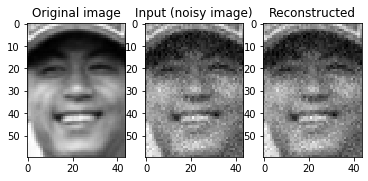

In [82]:
plot_compare(1, train, noisytrain, noisytrain)

### Escolhendo métricas que serão monitoradas

In [83]:
### Escolhendo métricas que serão monitoradas

# Funções custo e métricas podem ser utilizadas como métricas
metricas = [
            'mean_squared_error', 
            'mean_absolute_error',
            'binary_crossentropy', 
            'accuracy' 
            ] 

## Funcao custo customizada: SSIM

In [84]:
def ssim_loss(y_true, y_pred):
  return -tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

## Testando arquitetura

In [112]:
def make_autoencoder():
  # encoding
  inputs = Input(shape=(60, 44, 1)) 
  x = Conv2D(filters = 1, kernel_size = (3, 3), activation = 'relu', padding = 'same')(inputs) 
  x = MaxPooling2D(pool_size = 4, padding = 'same')(x)
  x = Conv2D(filters = 10, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x) 

  # decoding
  x = UpSampling2D(size = (2, 2))(x)
  x = Conv2D(filters = 10, kernel_size = (3, 3), activation = 'sigmoid', padding = 'same')(x) 
  x = UpSampling2D(size = (2, 2))(x)
  x = Conv2D(filters = 1, kernel_size = (3, 3), activation = 'sigmoid', padding = 'same')(x) 

  # autoencoder compilation
  autoencoder = Model(inputs, x)
  autoencoder.compile(optimizer = 'adam', loss = ssim_loss, metrics = metricas)
  return autoencoder
autoencoder = make_autoencoder()
historia = History()

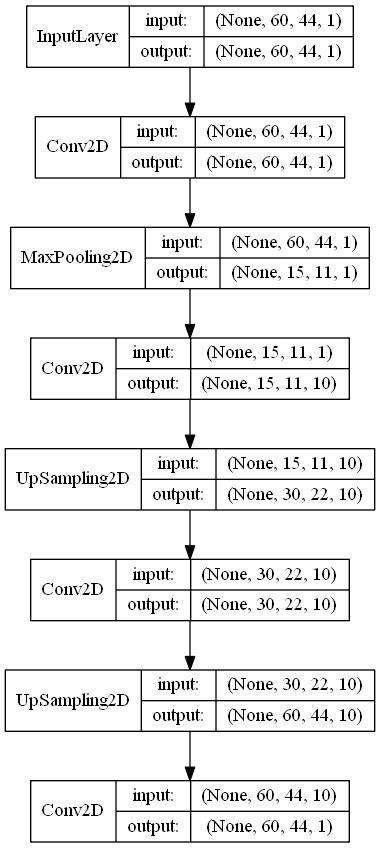

In [86]:
plot_model(autoencoder, show_shapes=True, show_layer_names=False)

In [88]:
autoencoder.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 60, 44, 1)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 60, 44, 1)         10        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 15, 11, 1)         0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 15, 11, 10)        100       
_________________________________________________________________
up_sampling2d_9 (UpSampling2 (None, 30, 22, 10)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 30, 22, 10)        910       
_________________________________________________________________
up_sampling2d_10 (UpSampling (None, 60, 44, 10)        0   

In [89]:
autoencoder.fit(noisytrain, train, epochs=40, batch_size=128, callbacks=[historia], validation_split = 0.1)

Train on 9527 samples, validate on 1059 samples
Epoch 1/40
9527/9527 [==============================] - 75s 8ms/step - loss: -0.3408 - mean_squared_error: 0.0308 - mean_absolute_error: 0.1374 - binary_crossentropy: 0.6896 - accuracy: 3.4630e-05 - val_loss: -0.5227 - val_mean_squared_error: 0.0147 - val_mean_absolute_error: 0.0941 - val_binary_crossentropy: 0.6568 - val_accuracy: 5.0076e-05
Epoch 2/40
9527/9527 [==============================] - 73s 8ms/step - loss: -0.6276 - mean_squared_error: 0.0106 - mean_absolute_error: 0.0750 - binary_crossentropy: 0.6476 - accuracy: 4.7552e-05 - val_loss: -0.6641 - val_mean_squared_error: 0.0086 - val_mean_absolute_error: 0.0671 - val_binary_crossentropy: 0.6432 - val_accuracy: 5.0434e-05
Epoch 3/40
9527/9527 [==============================] - 73s 8ms/step - loss: -0.6727 - mean_squared_error: 0.0075 - mean_absolute_error: 0.0618 - binary_crossentropy: 0.6405 - accuracy: 4.7990e-05 - val_loss: -0.6806 - val_mean_squared_error: 0.0068 - val_mean_a

Epoch 25/40
9527/9527 [==============================] - 72s 8ms/step - loss: -0.7215 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0488 - binary_crossentropy: 0.6349 - accuracy: 4.8626e-05 - val_loss: -0.7216 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0482 - val_binary_crossentropy: 0.6348 - val_accuracy: 5.1864e-05
Epoch 26/40
9527/9527 [==============================] - 72s 8ms/step - loss: -0.7219 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0487 - binary_crossentropy: 0.6348 - accuracy: 4.8626e-05 - val_loss: -0.7221 - val_mean_squared_error: 0.0049 - val_mean_absolute_error: 0.0482 - val_binary_crossentropy: 0.6348 - val_accuracy: 5.1864e-05
Epoch 27/40
9527/9527 [==============================] - 72s 8ms/step - loss: -0.7222 - mean_squared_error: 0.0050 - mean_absolute_error: 0.0486 - binary_crossentropy: 0.6347 - accuracy: 4.8626e-05 - val_loss: -0.7224 - val_mean_squared_error: 0.0050 - val_mean_absolute_error: 0.0487 - val_binary_crossentro

In [90]:
pred_train = autoencoder.predict(noisytrain) # in sample
pred_test = autoencoder.predict(noisytest) # out of sample

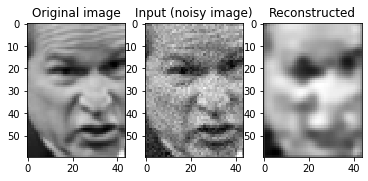

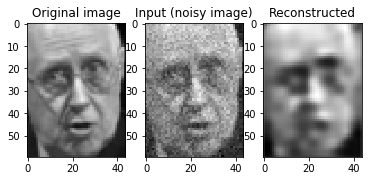

In [91]:
plot_compare(25, test, noisytest, pred_test) # out of sample prediction

plot_compare(15, train, noisytrain, pred_train) # in sample prediction - should be better

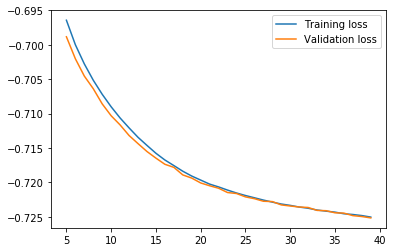

In [92]:
start = 5
finish = 40

y1 = historia.history['loss'][start:finish]
y2 = historia.history['val_loss'][start:finish]
x = range(start, finish)
sns.lineplot(x, y1, label = 'Training loss')
sns.lineplot(x, y2, label = 'Validation loss')

In [93]:
scipy.stats.describe(pred_train[0].flatten())

DescribeResult(nobs=2640, minmax=(0.19508728, 0.6779443), mean=0.4530771, variance=0.008073043, skewness=-0.23363281786441803, kurtosis=-0.3384055001106434)

In [94]:
mse_list_treino = np.zeros(len(pred_train))
for i in range(len(pred_train)):
    mse_list_treino[i] = np.mean((pred_train[i] - noisytrain[i])**2)
    
mse_list_teste = np.zeros(len(pred_test))
for i in range(len(pred_test)):
    mse_list_teste[i] = np.mean((pred_test[i] - noisytest[i])**2)


Text(0.5, 1.0, 'MSE(1) distribution')

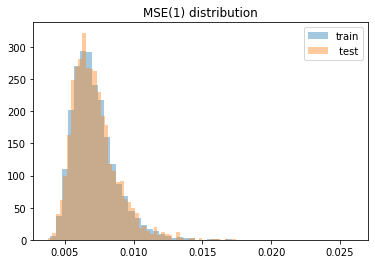

In [95]:
sns.distplot(mse_list_treino, label = 'train', norm_hist=True, kde=False)
sns.distplot(mse_list_teste, label = ' test', norm_hist=True, kde=False)
plt.legend()
plt.title("MSE(1) distribution")

#plt.xlim(0.0015, 0.0040)

In [96]:
scipy.stats.describe(mse_list_treino)

DescribeResult(nobs=10586, minmax=(0.003907921120273108, 0.025935961795031413), mean=0.007150503519581399, variance=2.604714696445282e-06, skewness=1.4220298994434102, kurtosis=4.8659455345268245)

In [97]:
scipy.stats.describe(mse_list_teste)

DescribeResult(nobs=2647, minmax=(0.0038162379148745074, 0.01746097637519831), mean=0.007160022637649018, variance=2.660970016753521e-06, skewness=1.3348637278282711, kurtosis=3.287301077986781)

#### MSE versão 2

In [98]:
mse_list_treino = np.zeros(len(pred_train))
for i in range(len(pred_train)):
    mse_list_treino[i] = np.mean((pred_train[i] - train[i])**2)
    
mse_list_teste = np.zeros(len(pred_test))
for i in range(len(pred_test)):
    mse_list_teste[i] = np.mean((pred_test[i] - test[i])**2)


Text(0.5, 1.0, 'MSE(2) distribution')

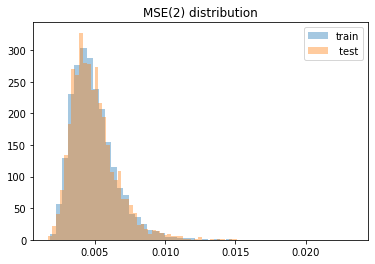

In [99]:
sns.distplot(mse_list_treino, label = 'train', norm_hist=True, kde=False)
sns.distplot(mse_list_teste, label = ' test', norm_hist=True, kde=False)
plt.legend()
plt.title("MSE(2) distribution")

#plt.xlim(0.0015, 0.0040)

In [100]:
scipy.stats.describe(mse_list_treino)

DescribeResult(nobs=10586, minmax=(0.0018184780572952878, 0.02335369383219215), mean=0.004910532858433238, variance=2.5582417303683703e-06, skewness=1.422946858514628, kurtosis=4.796383478021633)

In [101]:
scipy.stats.describe(mse_list_teste)

DescribeResult(nobs=2647, minmax=(0.0016895062712828672, 0.015083700146412532), mean=0.004920723656414713, variance=2.6370508060341843e-06, skewness=1.3401426052694558, kurtosis=3.3131290586212083)

##### SSIM

In [102]:
from skimage import measure

In [103]:
ssim_list_treino = np.zeros(len(pred_train))
for i in range(len(pred_train)):
    ssim_list_treino[i] = measure.compare_ssim(noisytrain[i,:,:,0], pred_train[i,:,:,0])
    
ssim_list_teste = np.zeros(len(pred_test))
for i in range(len(pred_test)):
    ssim_list_teste[i] = measure.compare_ssim(noisytest[i,:,:,0], pred_test[i,:,:,0])

C:\Users\User\Anaconda3\lib\site-packages\skimage\measure\_structural_similarity.py:155: UserWarning: Inputs have mismatched dtype.  Setting data_range based on X.dtype.
  warn("Inputs have mismatched dtype.  Setting data_range based on "


Text(0.5, 1.0, 'SSIM(1) distribution - train/test')

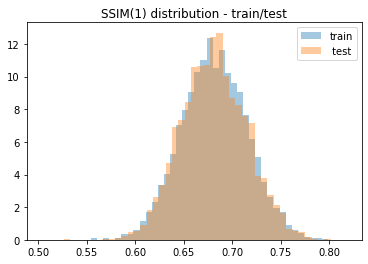

In [104]:
sns.distplot(ssim_list_treino, label = 'train', norm_hist=True, kde=False)
sns.distplot(ssim_list_teste, label = ' test', norm_hist=True, kde=False)
plt.legend()
plt.title("SSIM(1) distribution - train/test")

In [105]:
scipy.stats.describe(ssim_list_treino)

DescribeResult(nobs=10586, minmax=(0.504046454681899, 0.8180040980699848), mean=0.6816114337319302, variance=0.0011599771938132298, skewness=-0.024271247060115197, kurtosis=0.01858998279132873)

In [106]:
scipy.stats.describe(ssim_list_teste)

DescribeResult(nobs=2647, minmax=(0.5265797151467889, 0.8017238282648912), mean=0.6810738113694116, variance=0.0011455855728770455, skewness=0.043229464590057026, kurtosis=-0.03338557144781529)

In [107]:
ssim_list_treino = np.zeros(len(pred_train))
for i in range(len(pred_train)):
    ssim_list_treino[i] = measure.compare_ssim(train[i,:,:,0], pred_train[i,:,:,0])
    
ssim_list_teste = np.zeros(len(pred_test))
for i in range(len(pred_test)):
    ssim_list_teste[i] = measure.compare_ssim(test[i,:,:,0], pred_test[i,:,:,0])

Text(0.5, 1.0, 'SSIM(2) distribution - train/test')

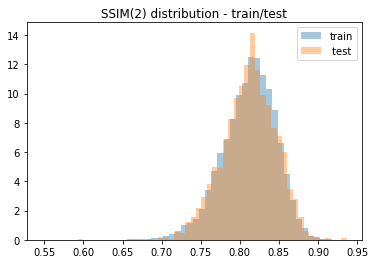

In [108]:
sns.distplot(ssim_list_treino, label = 'train', norm_hist=True, kde=False)
sns.distplot(ssim_list_teste, label = ' test', norm_hist=True, kde=False)
plt.legend()
plt.title("SSIM(2) distribution - train/test")

In [109]:
scipy.stats.describe(ssim_list_treino)

DescribeResult(nobs=10586, minmax=(0.5472049481240399, 0.9338330839743657), mean=0.811989379909556, variance=0.0011485490226641097, skewness=-0.4899835138769374, kurtosis=0.6861829630938239)

In [110]:
scipy.stats.describe(ssim_list_teste)

DescribeResult(nobs=2647, minmax=(0.5925770401642074, 0.9365146989030375), mean=0.8117190857804774, variance=0.0011539043761179715, skewness=-0.3489865732678646, kurtosis=0.6163941031399478)